In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Exploratory Data Analysis (EDA)

The cleaned data was stored in ``bike_weather_daily.csv``. 
We plot daily bike usage as a time series.

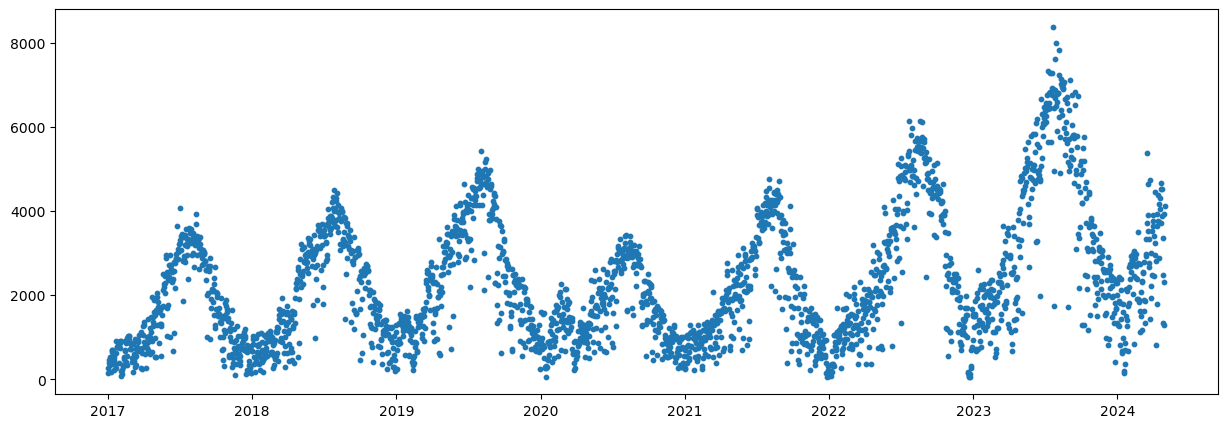

In [2]:
# The original cleaned data
df= pd.read_csv('bike_weather_daily.csv',parse_dates=['Date'])

# Re-index the data set using dates
df.set_index(df['Date'], inplace=True)
df.drop(columns=['Date'], inplace=True)

# Plot the number of bike uses as a time series
plt.figure(figsize=(15, 5))
plt.scatter(df.index, df['num_trips'], s = 10)
plt.show()

As a time series, the data clearly demonstrates a trend and seasonality. We expect that the trend is due to the increasing demand for rental bikes per year (except for the 2020-2021 period, when COVID took place). Since the increasing trend is not reflected by any weather variables, we want to detrend the data to obtain a time series with no trend and only seasonality.

# Detrending

To find the trend, we need to remove seasonality. Our first estimate for seasonality is to simply repeat the 2017 data over and over. After removing the seasonality, we fit the trend using the following methods.

## Method 1: Piecewise linear regressions (Multiplicative). 

The detrended data was stored in the file ``bikeshare_train_data_pcwsdetrend_mult.csv``.

In [3]:
train_df = pd.read_csv('bikeshare_train_data_pcwsdetrend_mult.csv',parse_dates=['Date'])

# Use dates as indices
train_df.set_index(train_df['Date'], inplace=True)
train_df.drop(columns=['Date'], inplace=True)

train_df.rename(columns={"adj_num_trips": "detrend_pcws", "trend_val":"trend_pcws"}, inplace =True)

## Method 2: Detrending using STL (Additive)

Alternatively, we can use the statsmodels package STL.

In [4]:
from statsmodels.tsa.seasonal import STL

In [5]:
# Apply the STL method, the default period is 365 days
default_period = 365

stl = STL(df['num_trips'], period = default_period)
result = stl.fit()

trend = result.trend
seasonal = result.seasonal
residual = result.resid

# (Optional) Plot the trend
# plt.plot(df.index,trend)
# plt.title('Trend')

In [6]:
# Remove both seasonality and trend from the original data
deseasonalized = df['num_trips'] - seasonal
detrended = df['num_trips'] - trend

In [7]:
# Add the newly detrended data to the training set
train_df['detrend_STL'] = detrended[:len(train_df)]
train_df['trend_STL'] = trend[:len(train_df)]

## Comparing different detrending methods

In [8]:
# Our training set with four different detrending methods
train_df.head()

,day_length,min_temp,max_temp,mean_temp,temp_diff,hdd,cdd,rain,snow,total_precip,...,mean_ret_temp,mean_ride_temp,total_dist,total_duration,ebike_trips,num_trips,detrend_pcws,trend_pcws,detrend_STL,trend_STL
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,497.133333,-2.3,2.2,-0.1,4.5,18.1,0.0,0.0,0.0,0.0,...,4.296296,3.925926,338025.0,232693.0,0.0,162,152.672085,1.061098,-1218.004632,1380.004632
2017-01-02,498.133333,-6.0,1.4,-2.3,7.4,20.3,0.0,0.0,0.0,0.0,...,3.688889,3.203704,660054.0,382729.0,0.0,270,254.394287,1.061345,-1110.987367,1380.987367
2017-01-03,499.133333,-7.8,0.4,-3.7,8.2,21.7,0.0,0.0,0.0,0.0,...,1.791667,1.299479,635395.0,376013.0,0.0,384,361.721069,1.061591,-997.970892,1381.970892
2017-01-04,501.133333,-8.4,2.2,-3.1,10.6,21.1,0.0,0.0,0.0,0.0,...,3.643478,3.205435,766082.0,376721.0,0.0,460,433.210952,1.061838,-922.955207,1382.955207
2017-01-05,502.133333,-6.6,0.7,-3.0,7.3,21.0,0.0,0.0,0.0,0.0,...,3.524809,3.062977,888222.0,524933.0,0.0,524,493.369072,1.062085,-859.940317,1383.940317


Let's visualize the effects of different detrending methods. 

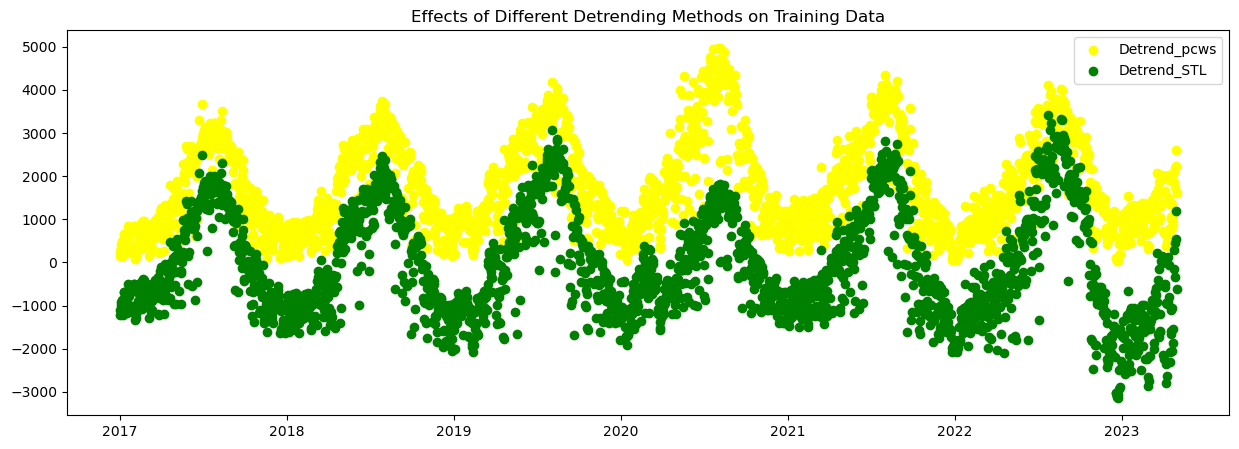

In [9]:
train_dates = train_df.index

plt.figure(figsize=(15, 5))

plt.scatter(train_dates, train_df['detrend_pcws'], label='Detrend_pcws', color = 'yellow')
plt.scatter(train_dates, train_df['detrend_STL'], label='Detrend_STL', color = 'green')

plt.title('Effects of Different Detrending Methods on Training Data')
plt.legend()
plt.show()

## Test Data


We perform the same task (adding different versions of detrended data) for the test set.

In [10]:
# Loading in the test data
test_df =  pd.read_csv('bikeshare_test_data_pcwsdetrend_mult.csv',parse_dates=['Date'])

# Use dates as indices
test_df.set_index(test_df['Date'], inplace=True)
test_df.drop(columns=['Date'], inplace=True)
test_df.rename(columns={"adj_num_trips": "detrend_pcws", "trend_val":"trend_pcws"}, inplace =True)

# Add the detrended data using STL
test_df['detrend_STL'] = detrended[-len(test_df):]
test_df['trend_STL'] = trend[-len(test_df): ]

and visualize the effects

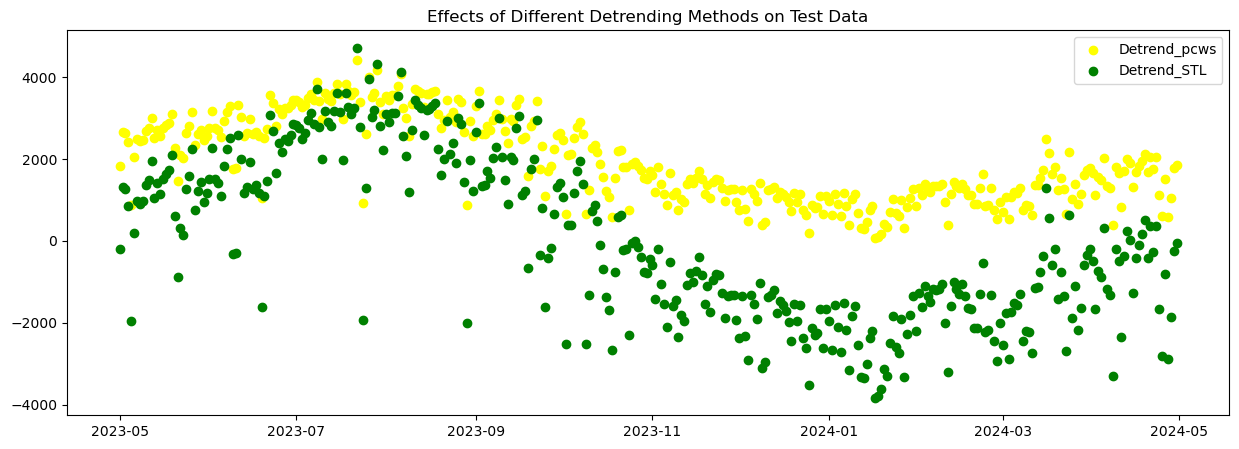

In [11]:
test_dates = test_df.index

plt.figure(figsize=(15, 5))

plt.scatter(test_dates, test_df['detrend_pcws'], label='Detrend_pcws', color = 'yellow')
plt.scatter(test_dates, test_df['detrend_STL'], label='Detrend_STL', color = 'green')

plt.title('Effects of Different Detrending Methods on Test Data')
plt.legend()
plt.show()

# Testing different models

In [12]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

 The following function compares different modeling approaches

- The ``model`` argument takes a model object, e.g., LinearRegression, KNN
- The variable ``X_train`` depends on how we select the features 
- The variable ``y_train`` depends on how we detrend the data
- ``n`` is the number of cross-validations

The function returns the average root MSE over the validation sets, predicted values, and the residues.

In [13]:
def test(model, X_train, y_train, n):
    
    kfold = KFold(n_splits = n, shuffle = True, random_state = 416)
    total_rmse = 0
    
    for train_index, test_index in kfold.split(X_train):
    
        X_tt = X_train.iloc[train_index]
        y_tt = y_train.iloc[train_index]
    
        X_val = X_train.iloc[test_index]
        y_val = y_train.iloc[test_index]
    
        ## Fit the model
        model.fit(X_tt,y_tt)

        # Make the prediction
        
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        total_rmse += rmse

    predict_values = model.predict(X_train)
    residues = y_train - model.predict(X_train)
    
    return total_rmse/n, model.predict(X_train), residues

## Preliminary models

In [14]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor

In [15]:
# Make a linear regression model
reg = LinearRegression()

# Make some ridge and lasso regression models
alphas=  [0.000001,.00001,.0001,.001,.01,.1,.25,.5,.75,1,5,10,25,50,100,1000,10000]
ridge_models = [Ridge(alpha = alpha_val) for alpha_val in alphas]
lasso_models = [Lasso(alpha = alpha_val) for alpha_val in alphas]

# Make some KNR models
knrs_euc = [KNeighborsRegressor(i, metric='euclidean') for i in list(range(2, 50))]
knrs_man = [KNeighborsRegressor(i, metric='manhattan') for i in list(range(2, 50))]

# Make a list of models
models = [reg] + ridge_models + lasso_models + knrs_euc + knrs_man

## Defining ``X_train`` and ``y_train``

In [16]:
from sklearn.preprocessing import StandardScaler

In [27]:
features = ['day_length', 'mean_dep_temp', 'total_precip']

X_train = train_df[features].copy()

# Scaling the data
scaler = StandardScaler().set_output(transform='pandas')
X_train_scaled = scaler.fit_transform(X_train)

# The y_train values corresponding to different detrending methods
y_trains = [train_df['detrend_pcws'], train_df['detrend_STL']]

## Testing the models (using 5-fold cross validations)

In [28]:
%%time
# Make a table of average rmses
rmse_table = pd.DataFrame()

for i, y_train in enumerate(y_trains):
    rmses = [test(model, X_train_scaled, y_train, 5)[0] for model in models]
    rmse_table[f'y_train_{i+1}'] = rmses
    rmse_table.index = [f'model_{i+1}' for i in range(len(models))]

CPU times: total: 15.8 s
Wall time: 36 s


In [29]:
rmse_table

,y_train_1,y_train_2
model_1,446.995198,509.701383
model_2,446.995198,509.701383
model_3,446.995198,509.701383
model_4,446.995197,509.701382
model_5,446.995191,509.701379
...,...,...
model_127,389.122008,456.045376
model_128,389.052807,456.248943
model_129,389.068895,456.344829
model_130,389.222833,456.511300


In [30]:
# Finding the minimum rmse and its index
min_value = rmse_table.min().min()
min_index = rmse_table.stack().idxmin()

print(f'The model with the least average root MSE is {min_index}. Its average RMSE is {min_value:.4f}')

The model with the least average root MSE is ('model_128', 'y_train_1'). Its average RMSE is 389.0528


## Plotting the predicted values and the residues

KNeighborsRegressor(metric='manhattan', n_neighbors=46)


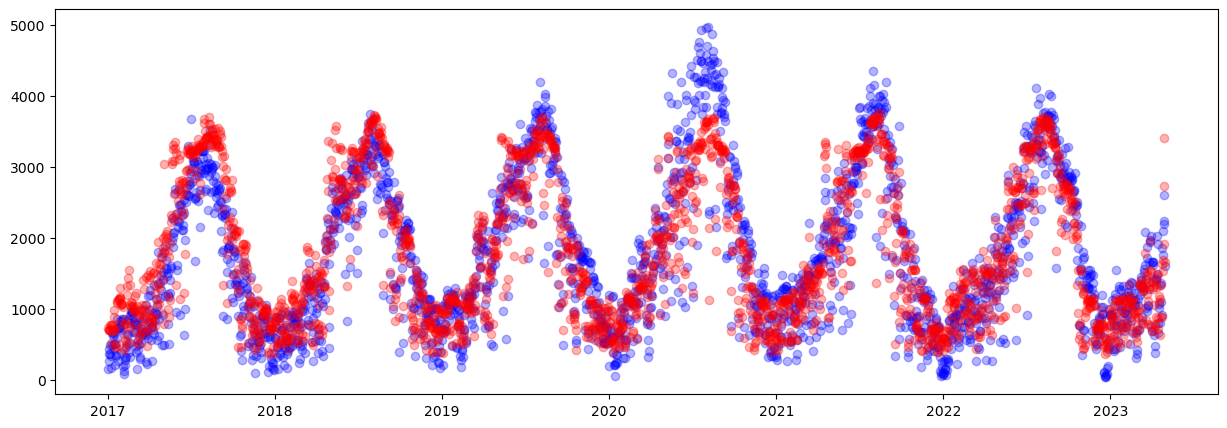

In [31]:
nice_model = models[127]
y_train =  y_trains[0]
print(nice_model)

model_data = test(nice_model, X_train_scaled, y_trains[0], 5)

plt.figure(figsize=(15, 5))
plt.scatter(X_train_scaled.index, y_train, label='Actual', color = 'blue', alpha = 0.3)
plt.scatter(X_train_scaled.index, model_data[1], label='Predicted', color='red', alpha = 0.3)
plt.show()

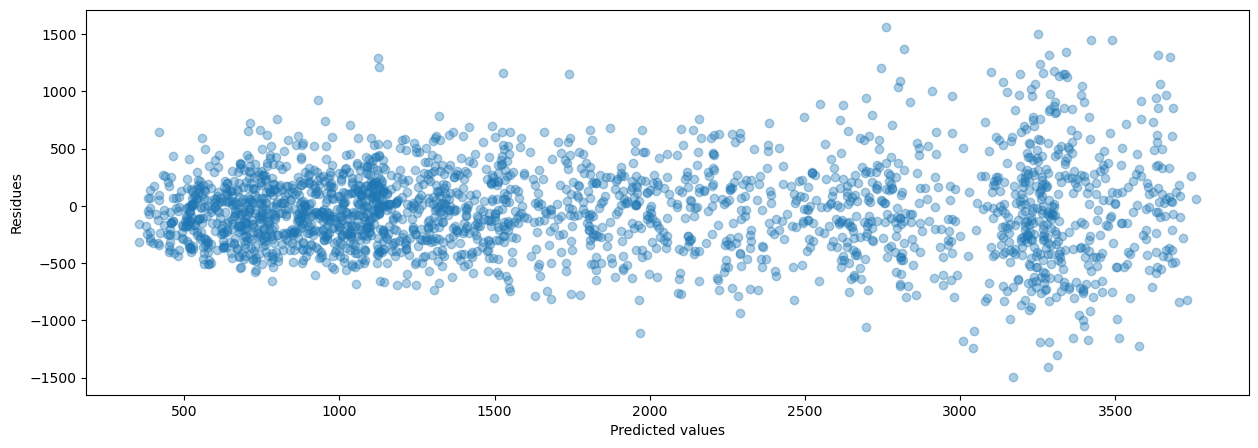

In [32]:
plt.figure(figsize=(15, 5))
plt.scatter(model_data[1], model_data[2], alpha = 0.37)
plt.xlabel('Predicted values')
plt.ylabel('Residues')
plt.show()

## Performance on the testing data

In [33]:
X_test = test_df[features].copy()
X_test_scaled = scaler.fit_transform(X_test)

In [34]:
pred_val = nice_model.predict(X_test_scaled) * test_df['trend_pcws']

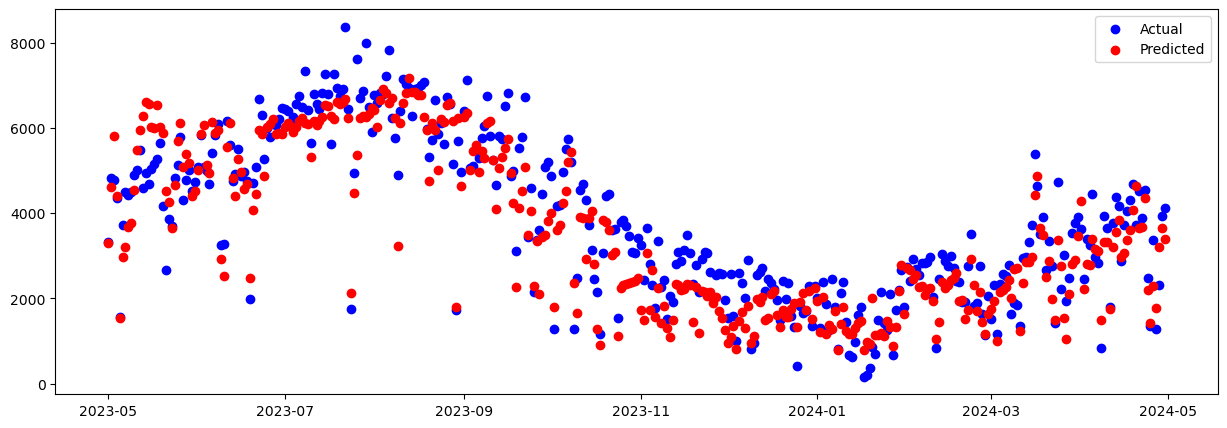

In [35]:
plt.figure(figsize=(15, 5))
plt.scatter(X_test.index, test_df['num_trips'], label='Actual', color = 'blue')
plt.scatter(X_test.index, pred_val, label='Predicted', color='red')
plt.legend()
plt.show()

In [36]:
# Calculate the root mean square error
np.sqrt(mean_squared_error(pred_val, test_df['num_trips']))

687.458571601457